In [1]:
%load_ext autoreload
%autoreload 2

# MTCNN

In [36]:
def fixed_image_standardization(image_tensor):
    processed_tensor = (image_tensor - 127.5) / 128.0
    return processed_tensor

In [42]:
import requests
from io import BytesIO
from PIL import Image

r = requests.get('https://i.insider.com/555264b0ecad041477fbd87e?width=1100&format=jpeg&auto=webp')
img = Image.open(BytesIO(r.content))



In [62]:
min_face_size = 20
factor = 0.709

In [258]:
from facenet_pytorch.models.mtcnn import PNet
from torchvision.transforms import Compose, Resize, Normalize, ToTensor


transform = Compose([Resize((160, 160)), ToTensor()])
x = transform(img)
batch = torch.stack([x, x.clone()])
pnet = PNet(pretrained=True)

regions, probs = pnet(batch)

regions.shape, probs.shape

regions[0].shape

torch.Size([4, 75, 75])

### pyramid scaling

In [244]:
from dataclasses import dataclass
from torch.nn.functional import interpolate
from torch import Tensor

@dataclass
class PyramidScaling:
    min_size: int = 20
    factor: float = 0.709
    min_scale: int = 12
        
    def __call__(self, x:Tensor) -> Tensor:
        b, c, w , h = x.shape
        scale = self.min_scale / self.min_size
        scaled = [interpolate(x, scale_factor=scale, mode='area')]
        size = w * scale
        scales = [scale]
        while scaled[-1].shape[-1] > self.min_scale:
            scale = scale * factor
            scaled.append(interpolate(x, scale_factor=scale, mode='area'))
            scales.append(scale)
        return scaled, scales


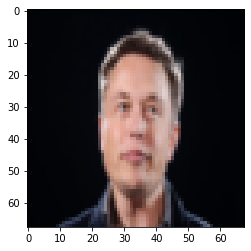

In [357]:
import matplotlib.pyplot as plt
pyramids, _ = PyramidScaling()(batch)
fig = plt.figure()

plt.imshow(pyramids[1][1].permute(1,2,0))

In [358]:
pyramids[1]

tensor([[[[0.0083, 0.0083, 0.0095,  ..., 0.0039, 0.0039, 0.0039],
          [0.0109, 0.0109, 0.0114,  ..., 0.0039, 0.0039, 0.0039],
          [0.0118, 0.0118, 0.0118,  ..., 0.0039, 0.0039, 0.0049],
          ...,
          [0.0062, 0.0075, 0.0078,  ..., 0.0078, 0.0078, 0.0069],
          [0.0048, 0.0057, 0.0075,  ..., 0.0078, 0.0078, 0.0074],
          [0.0039, 0.0039, 0.0049,  ..., 0.0065, 0.0070, 0.0065]],

         [[0.0122, 0.0122, 0.0134,  ..., 0.0078, 0.0078, 0.0078],
          [0.0148, 0.0148, 0.0154,  ..., 0.0078, 0.0078, 0.0078],
          [0.0157, 0.0157, 0.0157,  ..., 0.0078, 0.0078, 0.0088],
          ...,
          [0.0101, 0.0114, 0.0118,  ..., 0.0118, 0.0118, 0.0108],
          [0.0087, 0.0096, 0.0114,  ..., 0.0118, 0.0118, 0.0113],
          [0.0078, 0.0078, 0.0088,  ..., 0.0105, 0.0109, 0.0105]],

         [[0.0279, 0.0279, 0.0291,  ..., 0.0235, 0.0183, 0.0157],
          [0.0305, 0.0305, 0.0310,  ..., 0.0235, 0.0209, 0.0196],
          [0.0314, 0.0314, 0.0314,  ..., 0

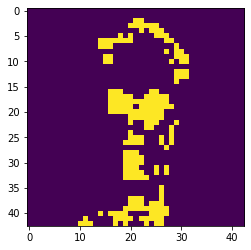

In [355]:
fig = plt.figure()

plt.imshow(mask[0])

In [356]:
mask = probs[:,1] >= 0.2
print(mask.shape)
tmp = regs.permute(1,0,2,3)
tmp[:, mask].shape

torch.Size([2, 43, 43])


torch.Size([4, 408])

In [298]:
regs[:,1][(probs[:,1] > 0.6)].shape

torch.Size([4])

In [343]:
import matplotlib.pyplot as plt

with torch.no_grad():
    for (pyramid, scale) in zip(*PyramidScaling()(batch)):
        regs, probs = pnet(pyramid) 
        bbox, inds = generateBoundingBox(regs, probs[:,1], scale, 0.6)
        print(bbox[0])
        break

tensor([ 8.5000e+01,  6.5000e+01,  1.0300e+02,  8.3000e+01,  8.2387e-01,
        -3.6634e-02, -1.7739e-02, -9.7837e-02,  1.4572e-01])


In [188]:
# Create scale pyramid
scale = 12 / min_face_size
scaled = 160 * scale
scales = []
while scaled >= 12:
    scales.append(scale)
    scale = scale * factor
    scaled = scaled * factor
    

In [189]:
[160 *  s for s in scales]

[96.0,
 68.064,
 48.257375999999994,
 34.21447958399999,
 24.258066025055992,
 17.1989688117647,
 12.194068887541171]

In [83]:
[160 *  s for s in scales]

[96.0,
 68.064,
 48.257375999999994,
 34.21447958399999,
 24.258066025055992,
 17.1989688117647,
 12.194068887541171]

In [2]:
from glasses.models.segmentation.fpn import *
from glasses.models.segmentation.unet import *
from functools import partial
from glasses.models import *
from glasses.models.classification.resnet import ResNetBottleneckBlock

model = PFPN(encoder=partial(ResNetEncoder, block=ResNetBottleneckBlock, depths=[2,2,2,2]))
# model = FPN()
# model = PPFN()
out = model(torch.randn(1,1,224,224))
print(out.shape)
# model

# [o.shape for o in out]
# model.encoder.features_widths

torch.Size([1, 2, 224, 224])


In [3]:
from glasses.models.classification.efficientnet import EfficientNetEncoder

EfficientNetEncoder().features_widths


[32, 24, 40, 80, 192]

In [4]:
import numpy as np
a = [1, 2, 2, 2, 1, 2, 1]

np.arange(len(a))[np.array(a) == 2]

array([1, 2, 3, 5])

# AutoModel

In [29]:
from glasses.models.AutoModel import AutoModel
from glasses.models.AutoConfig import AutoConfig
import torch

In [30]:
AutoModel.from_name('efficientnet_b0').encoder.features_widths

[32, 24, 40, 80]

In [31]:
len(AutoModel.from_name('efficientnet_b2').encoder.stages)

4

In [32]:

unet = UNet.from_encoder(partial(AutoModel.from_name, 'efficientnet_b2'))
unet(torch.randn((1,1,384,384)))

tensor([[[[ 1.2522e-01,  1.2171e-01,  5.8732e-02,  ..., -2.8594e-01,
            1.2283e-01,  1.5014e-01],
          [ 4.0246e-02,  1.0498e-01,  1.1626e-01,  ...,  2.2126e-01,
            3.3360e-01,  3.0549e-01],
          [-2.3279e-01, -2.1874e-01, -2.6462e-01,  ...,  6.0497e-01,
            1.0875e-01,  1.5122e-01],
          ...,
          [-1.1389e-01, -1.3482e-01,  2.2659e-01,  ..., -6.1285e-02,
           -8.7416e-02, -2.8309e-02],
          [-1.5989e-01,  3.4743e-02, -2.9768e-01,  ...,  1.0780e-01,
           -4.7979e-01,  2.3952e-01],
          [ 7.9296e-02,  1.1357e-02,  1.0315e-01,  ..., -7.1404e-02,
           -3.0633e-01, -3.6861e-01]],

         [[ 2.1440e-01, -1.6960e-01,  7.0719e-02,  ..., -8.5503e-02,
            4.1183e-04, -1.1782e-01],
          [-6.3867e-02,  1.7682e-02,  8.4108e-02,  ...,  6.0590e-01,
           -1.5115e-01,  3.4385e-01],
          [ 4.7620e-01, -2.2236e-01,  8.0767e-02,  ...,  3.6425e-01,
            2.6487e-01, -8.4237e-02],
          ...,
     

# Benchmark

In [7]:
a = [1,2,3]
b = [1,2,3]

a == b

True

In [8]:
 {'regnetx_002' : RegNetScaler()(w_0 = 24, w_a = 36.44, w_m = 2.49, group_w = 8, depth = 13 ),
    'regnetx_004' : RegNetScaler()(w_0 = 24, w_a = 24.48, w_m = 2.54, group_w = 16, depth = 22 ),
    'regnetx_006' : RegNetScaler()(w_0 = 48, w_a = 36.97, w_m = 2.24, group_w = 24, depth = 16 ),
    'regnetx_008' : RegNetScaler()(w_0 = 56, w_a = 35.73, w_m = 2.28, group_w = 16, depth = 16 ),
    'regnetx_016' : RegNetScaler()(w_0 = 80, w_a = 34.01, w_m = 2.25, group_w = 24, depth = 18 ),
    'regnetx_032' : RegNetScaler()(w_0 = 88, w_a = 26.31, w_m = 2.25, group_w = 48, depth = 25 ),
    'regnetx_040' : RegNetScaler()(w_0 = 96, w_a = 38.65, w_m = 2.43, group_w = 40, depth = 23 ),
    'regnetx_064' : RegNetScaler()(w_0 = 184, w_a = 60.83, w_m = 2.07, group_w = 56, depth = 17 ),
    'regnetx_080' : RegNetScaler()(w_0 = 80, w_a = 49.56, w_m = 2.88, group_w = 120, depth = 23 ),
    'regnetx_120' : RegNetScaler()(w_0 = 168, w_a = 73.36, w_m = 2.37, group_w = 112, depth = 19 ),
    'regnetx_160' : RegNetScaler()(w_0 = 216, w_a = 55.59, w_m = 2.1, group_w = 128, depth = 22 ),
    'regnetx_320' : RegNetScaler()(w_0 = 320, w_a = 69.86, w_m = 2.0, group_w = 168, depth = 23 ),
    'regnety_002' : RegNetScaler()(w_0 = 24, w_a = 36.44, w_m = 2.49, group_w = 8, depth = 13 ),
    'regnety_004' : RegNetScaler()(w_0 = 48, w_a = 27.89, w_m = 2.09, group_w = 8, depth = 16 ),
    'regnety_006' : RegNetScaler()(w_0 = 48, w_a = 32.54, w_m = 2.32, group_w = 16, depth = 15 ),
    'regnety_008' : RegNetScaler()(w_0 = 56, w_a = 38.84, w_m = 2.4, group_w = 16, depth = 14 ),
    'regnety_016' : RegNetScaler()(w_0 = 48, w_a = 20.71, w_m = 2.65, group_w = 24, depth = 27 ),
    'regnety_032' : RegNetScaler()(w_0 = 80, w_a = 42.63, w_m = 2.66, group_w = 24, depth = 21 ),
    'regnety_040' : RegNetScaler()(w_0 = 96, w_a = 31.41, w_m = 2.24, group_w = 64, depth = 22 ),
    'regnety_064' : RegNetScaler()(w_0 = 112, w_a = 33.22, w_m = 2.27, group_w = 72, depth = 25 ),
    'regnety_080' : RegNetScaler()(w_0 = 192, w_a = 76.82, w_m = 2.19, group_w = 56, depth = 17 ),
    'regnety_120' : RegNetScaler()(w_0 = 168, w_a = 73.36, w_m = 2.37, group_w = 112, depth = 19 ),
    'regnety_160' : RegNetScaler()(w_0 = 200, w_a = 106.23, w_m = 2.48, group_w = 112, depth = 18 ),
    'regnety_320' : RegNetScaler()(w_0 = 232, w_a = 115.89, w_m = 2.53, group_w = 232, depth = 20)}

NameError: name 'RegNetScaler' is not defined

# Clone

In [ ]:
from glasses.models import AutoModel, AutoConfig, EfficientNetLite
import timm
from transfer_weights import clone_model
from benchmark import benchmark

src = timm.create_model('tf_efficientnet_lite1', pretrained='True')
# dst = AutoModel.from_name('resnet34d')
dst = EfficientNetLite.efficientnet_lite1(mode='same')

In [ ]:
dst = clone_model(src, dst).eval()

In [ ]:
timm.list_models()

**SE features are in_features / reduction not out_features / reduction**

In [ ]:
dst = clone_model(src, dst).eval()

In [ ]:
import torch

transform = AutoConfig.from_name('efficientnet_b0').transform

benchmark(src.cuda(), transform, batch_size=128)

In [ ]:

transform = AutoConfig.from_name('resnet18').transform

benchmark(src.cuda(), transform, batch_size=128)

# Pretrained weights

In [ ]:
from pathlib import Path

root = Path('/home/zuppif/Documents/glasses-weights/')

models = map(lambda x: x.stem, root.glob('*.pth'))

for model in models:
    print(f"'{model}': BasicUrlHandler('https://github.com/FrancescoSaverioZuppichini/glasses-weights/blob/main/{model}.pth?raw=true'),")

## FPN